<center>Заметка 9. 	GLM.</center>
<center>курс <q>Прикладной статистический анализ данных</q>.</center>
<center>Версия 1. 2 апреля 2021 г.</center>

# Кардиотокография

## Постановка задачи

Кардиотокография — диагностическая техника, фиксирующая сердцебиение плода и тонус матки и позволяющая оценить состояние эмбриона. Непосредственный результат наблюдений интерпретировать крайне сложно. Чтобы облегчить задачу диагностики, результаты кардиотокографии 1831 эмбрионов были классифицированы опытными специалистами на нормальные и патологические, а на основе показаний прибора был сгенерирован 21 признак. Ставится задача построения функции, определяющей вероятность наличия патологии по описанию кардиотокограммы и оценки вклада признаков.

## Решение

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats.distributions import chi2
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
data = pd.read_csv('CTG.csv', sep=',')
data.describe()

,LB,AC,FM,UC,DL,DS,DP,DR,ASTV,MSTV,ALTV,MLTV,Width,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Tendency
count,1831.000000,1831.000000,1831.000000,1831.000000,1831.000000,1831.000000,1831.000000,1831.0,1831.000000,1831.000000,1831.000000,1831.000000,1831.000000,1831.000000,1831.000000,1831.000000,1831.000000,1831.000000,1831.000000,1831.000000,1831.000000
mean,131.953577,3.126707,7.265975,3.914801,1.758056,0.003823,0.135991,0.0,44.587657,1.444566,6.755871,8.213654,73.875478,90.403058,164.278536,4.190060,0.336428,135.985254,132.975423,136.643364,0.302021
std,9.450274,3.671676,36.953844,2.776040,2.605566,0.061729,0.484254,0.0,16.715290,0.863467,16.066764,5.874919,37.769546,28.060771,18.181356,2.906922,0.689008,16.634624,15.662176,14.499635,0.612253
min,106.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,12.000000,0.200000,0.000000,0.000000,3.000000,50.000000,122.000000,0.000000,0.000000,60.000000,73.000000,77.000000,-1.000000
25%,125.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.0,30.000000,0.800000,0.000000,4.200000,41.000000,65.000000,152.000000,2.000000,0.000000,127.000000,124.000000,127.000000,0.000000
50%,132.000000,2.000000,0.000000,4.000000,0.000000,0.000000,0.000000,0.0,44.000000,1.300000,0.000000,7.500000,73.000000,89.000000,163.000000,4.000000,0.000000,136.000000,134.000000,137.000000,0.000000
75%,138.000000,5.000000,2.000000,6.000000,3.000000,0.000000,0.000000,0.0,58.000000,1.800000,4.000000,11.100000,102.000000,115.000000,175.000000,6.000000,0.000000,147.000000,144.000000,147.000000,1.000000
max,160.000000,26.000000,564.000000,17.000000,16.000000,1.000000,4.000000,0.0,87.000000,7.000000,91.000000,50.700000,180.000000,159.000000,238.000000,18.000000,10.000000,187.000000,182.000000,186.000000,1.000000


Посмотрим на распределения непрерывных признаков в классах:

In [ ]:
data_P = data[data.NSP =='P'].drop(columns=['NSP','DR'])
data_X = data[data.NSP =='N'].drop(columns=['NSP','DR'])

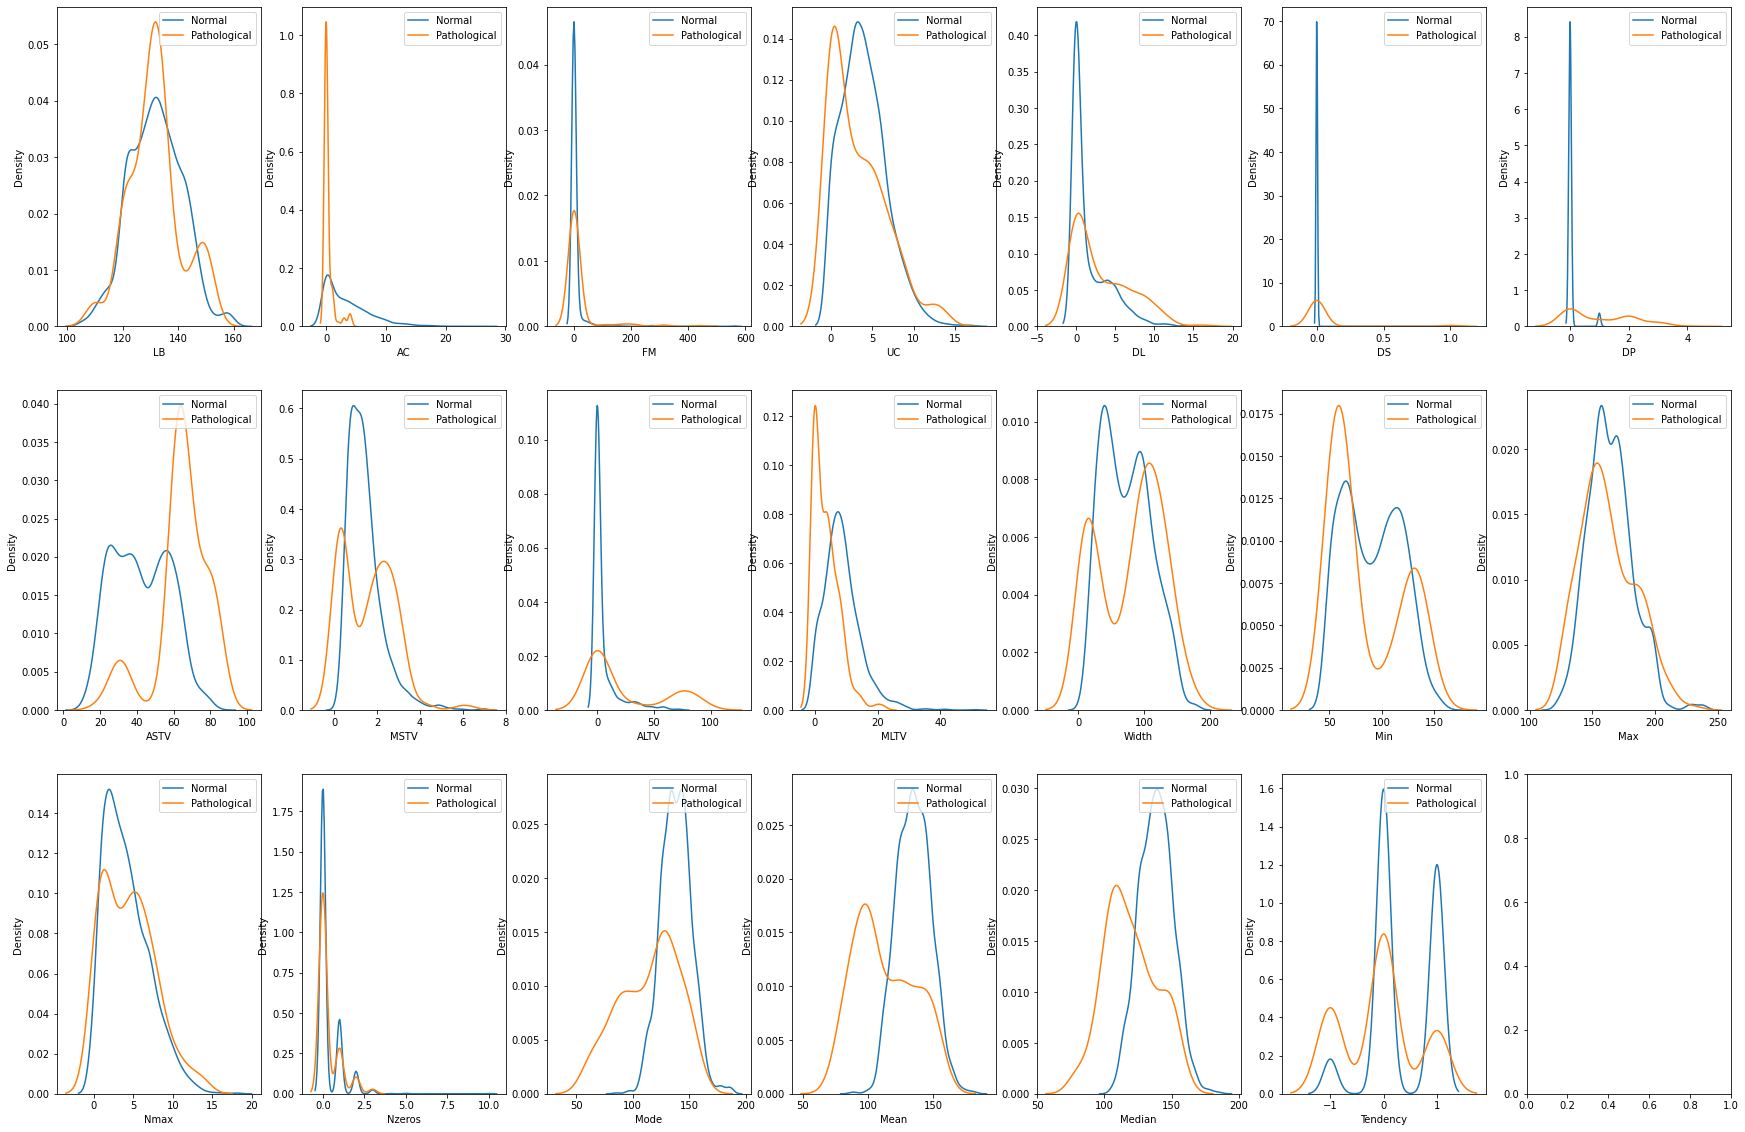

In [ ]:
fig, ax = plt.subplots(3, 7, figsize=(30,20))
ax = ax.ravel() 

for idx in range(len(data_X.columns)):
    sns.kdeplot(data_X.iloc[:,idx], ax = ax[idx])
    sns.kdeplot(data_P.iloc[:,idx], ax = ax[idx])
    ax[idx].legend(('Normal', 'Pathological'),loc='upper right')

Линейной разделимости по отдельным признакам нет.

Посмотрим на таблицы сопряжённости по категориальным признакам:

In [ ]:
pd.value_counts(data.NSP)

N    1655
P     176
Name: NSP, dtype: int64

In [ ]:
pd.crosstab(data.DS, data.NSP)

NSP,N,P
DS,,
0,1654,170
1,1,6


In [ ]:
pd.crosstab(data.DR, data.NSP)

NSP,N,P
DR,,
0,1655,176


In [ ]:
pd.crosstab(data.Tendency, data.NSP)

NSP,N,P
Tendency,,
-1,101,49
0,887,91
1,667,36


DR — константа, DS — почти константа, поэтому удалим эти признаки.

In [ ]:
data = data.drop(columns = ['DR', 'DS'])

Для предварительного отбора признаков построим одномерные модели по каждому фактору и оценим их значимость:

In [ ]:
data["NSP"] = (data["NSP"] == "P").astype(int)

In [ ]:
m0 = smf.glm('NSP ~ 1',
             data, family=sm.families.Binomial())
result_m0 = m0.fit()
result_m0.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    NSP   No. Observations:                 1831
Model:                            GLM   Df Residuals:                     1830
Model Family:                Binomial   Df Model:                            0
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -579.47
Date:                Thu, 01 Apr 2021   Deviance:                       1158.9
Time:                        21:45:31   Pearson chi2:                 1.83e+03
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.2411      0.079    -28.266      0.000      -2.396      -2.086
==============================================================================
"""

In [ ]:
#likelihood ratio
def lrtest(lmin, lmax):
    return(2*(lmax-lmin))

In [ ]:
Single_term = pd.DataFrame(columns=['features', 'p-val'])
for i in data.drop(columns = ['NSP']).columns:
    formula = 'NSP ~ 1 +' + i
    model = sm.formula.glm(formula,
                           family=sm.families.Binomial(), 
                           data=data).fit()
    lr = lrtest(result_m0.llf, model .llf)
    Single_term = Single_term.append({'features': i, 'p-val':  round(chi2.sf(lr, 1), 3)}, ignore_index=True)
Single_term

,features,p-val
0,LB,0.694
1,AC,0.000
2,FM,0.009
3,UC,0.001
4,DL,0.000
5,DP,0.000
6,ASTV,0.000
7,MSTV,0.041
8,ALTV,0.000
9,MLTV,0.000


## Модель 1
Многомерная модель со всеми предикторами, значимыми на уровне 0.25:

In [ ]:
data = data.drop(columns=['LB', 'Nzeros'])

In [ ]:
data['const'] = [1] * data.shape[0]
data['Tendency1']=1*(data.Tendency==1)
data['Tendency-1']=1*(data.Tendency==-1)
tendency = data['Tendency']
data = data.drop(columns = ['Tendency'])

In [ ]:
m1 = sm.GLM(data.NSP, data.drop(columns=['NSP']),
                       family=sm.families.Binomial())
result_m1 = m1.fit()
result_m1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    NSP   No. Observations:                 1831
Model:                            GLM   Df Residuals:                     1813
Model Family:                Binomial   Df Model:                           17
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -84.573
Date:                Thu, 01 Apr 2021   Deviance:                       169.15
Time:                        21:45:46   Pearson chi2:                 1.62e+03
No. Iterations:                    11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
AC            -1.6081      0.413     -3.894      0.000      -2.418      -0.799
FM             0.0138      0.006      2.343      0.019       0.002       0.025
UC            -0.6939      0.114     -6.076      0.000      -0.918      -0.470
DL             0.1436      0.120      1.198      0.231      -0.091       0.378
DP             4.7699      0.678      7.033      0.000       3.441       6.099
ASTV           0.1406      0.021      6.642      0.000       0.099       0.182
MSTV           0.4087      0.422      0.970      0.332      -0.417       1.235
ALTV           0.0767      0.013      5.706      0.000       0.050       0.103
MLTV          -0.0180      0.065     -0.277      0.782      -0.145       0.109
Width          0.0380      0.009      4.323      0.000       0.021       0.055
Min            0.0370      0.014      2.576      0.010       0.009       0.065
Max            0.0750      0.017      4.534      0.000       0.043       0.107
Nmax          -0.5866      0.169     -3.470      0.001      -0.918      -0.255
Mode          -0.1048      0.030     -3.457      0.001      -0.164      -0.045
Mean           0.0343      0.047      0.736      0.462      -0.057       0.126
Median        -0.1008      0.047     -2.132      0.033      -0.193      -0.008
const         -4.4965      3.387     -1.328      0.184     -11.135       2.142
Tendency1      1.8618      0.634      2.939      0.003       0.620       3.104
Tendency-1    -2.0489      0.813     -2.522      0.012      -3.641      -0.456
==============================================================================
"""

Проверим признаки на коллинеарность. Для этого подсчитаем коэффициент VIF(variance inflation factor):

In [ ]:
VIF = pd.DataFrame(columns=['features', 'VIF Factor'])
variables = result_m1.model.exog
for i in range(variables.shape[1]):
    VIF = VIF.append({'features':result_m1.params.index[i] , 'VIF Factor': variance_inflation_factor(variables, i)}, ignore_index=True)
VIF

/usr/local/lib/python3.7/dist-packages/statsmodels/stats/outliers_influence.py:185: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,features,VIF Factor
0,AC,1.844564
1,FM,1.092199
2,UC,1.296282
3,DL,2.480005
4,DP,1.683562
5,ASTV,1.599821
6,MSTV,2.489409
7,ALTV,1.530505
8,MLTV,1.668546
9,Width,inf


По всей видимости, коллинеарны признаки в группе Width, Min и Max. Удалим, к примеру, Width.

## Модель 2

Попробуем улучшить результат. 

In [ ]:
data = data.drop(columns = ['Width'])

In [ ]:
m2 = sm.GLM(data.NSP, data.drop(columns=['NSP']),
                       family=sm.families.Binomial())
result_m2 = m2.fit()
result_m2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    NSP   No. Observations:                 1831
Model:                            GLM   Df Residuals:                     1813
Model Family:                Binomial   Df Model:                           17
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -84.573
Date:                Thu, 01 Apr 2021   Deviance:                       169.15
Time:                        21:45:53   Pearson chi2:                 1.62e+03
No. Iterations:                    11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
AC            -1.6081      0.413     -3.894      0.000      -2.418      -0.799
FM             0.0138      0.006      2.343      0.019       0.002       0.025
UC            -0.6939      0.114     -6.076      0.000      -0.918      -0.470
DL             0.1436      0.120      1.198      0.231      -0.091       0.378
DP             4.7699      0.678      7.033      0.000       3.441       6.099
ASTV           0.1406      0.021      6.642      0.000       0.099       0.182
MSTV           0.4087      0.422      0.970      0.332      -0.417       1.235
ALTV           0.0767      0.013      5.706      0.000       0.050       0.103
MLTV          -0.0180      0.065     -0.277      0.782      -0.145       0.109
Min           -0.0010      0.017     -0.059      0.953      -0.035       0.033
Max            0.1129      0.022      5.076      0.000       0.069       0.157
Nmax          -0.5866      0.169     -3.470      0.001      -0.918      -0.255
Mode          -0.1048      0.030     -3.457      0.001      -0.164      -0.045
Mean           0.0343      0.047      0.736      0.462      -0.057       0.126
Median        -0.1008      0.047     -2.132      0.033      -0.193      -0.008
const         -4.4965      3.387     -1.328      0.184     -11.135       2.142
Tendency1      1.8618      0.634      2.939      0.003       0.620       3.104
Tendency-1    -2.0489      0.813     -2.522      0.012      -3.641      -0.456
==============================================================================
"""

Критерий отношения правдоподобия считает такую модель существенно лучше константы (то есть объясняемая переменная действительно зависит от выбранных факторов, в противном случае она бы лучше описывалась константой и случайной ошибкой):

In [ ]:
lr = lrtest(result_m0.llf,result_m2.llf)
print('Likelihood Ratio Test Of Nested Models, p: %.03f' % chi2.sf(lr, 1))

Likelihood Ratio Test Of Nested Models, p: 0.000


## Модели 3 и 4

Удалим незначимые признаки.

In [ ]:
data = data.drop(columns=['DL', 'MSTV', 'MLTV', 'Min', 'Mean'])

In [ ]:
m3 = sm.GLM(data.NSP, data.drop(columns=['NSP']),
                       family=sm.families.Binomial())
result_m3 = m3.fit()
result_m3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    NSP   No. Observations:                 1831
Model:                            GLM   Df Residuals:                     1818
Model Family:                Binomial   Df Model:                           12
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -85.997
Date:                Thu, 01 Apr 2021   Deviance:                       171.99
Time:                        21:46:00   Pearson chi2:                 1.28e+03
No. Iterations:                    11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
AC            -1.6671      0.403     -4.141      0.000      -2.456      -0.878
FM             0.0131      0.006      2.029      0.043       0.000       0.026
UC            -0.6692      0.111     -6.038      0.000      -0.886      -0.452
DP             4.7150      0.653      7.224      0.000       3.436       5.994
ASTV           0.1398      0.019      7.344      0.000       0.103       0.177
ALTV           0.0730      0.012      6.243      0.000       0.050       0.096
Max            0.1201      0.020      6.104      0.000       0.082       0.159
Nmax          -0.4950      0.140     -3.532      0.000      -0.770      -0.220
Mode          -0.1022      0.028     -3.713      0.000      -0.156      -0.048
Median        -0.0904      0.040     -2.248      0.025      -0.169      -0.012
const         -2.5359      2.741     -0.925      0.355      -7.909       2.837
Tendency1      1.8020      0.548      3.291      0.001       0.729       2.875
Tendency-1    -2.2949      0.755     -3.039      0.002      -3.775      -0.815
==============================================================================
"""

In [ ]:
lr = lrtest(result_m3.llf,result_m2.llf)
print('Likelihood Ratio Test Of Nested Models, p: %.03f' % chi2.sf(lr, 1))

Likelihood Ratio Test Of Nested Models, p: 0.091


По критерию отношения правдоподобия ухудшения не произошло. В полученной модели значимы все признаки.

Попробуем добавлять в линейную модель попарные взаимодействия (при этом для простоты не будем брать взаимодействия с категориальным признаком).

In [ ]:
from itertools import combinations
cc = list(combinations(data.drop(columns = ['NSP', 'Tendency1', 'Tendency-1', 'const']).columns, 2))
for c in cc:
    name_str = str(c).replace("'", "")
    data[name_str] = data[c[0]]*data[c[1]]

In [ ]:
number_all_param = data.columns.get_loc('Tendency-1')

In [ ]:
Single_term = pd.DataFrame(columns=['features', 'p-val'])
for i in range(1,len(cc)):
    model = sm.GLM(data.NSP,  
                pd.concat([data.drop(columns='NSP').iloc[:, :number_all_param],
                           data.iloc[:, number_all_param+i]], 
                           axis=1),
                       family=sm.families.Binomial()).fit()
    lr = lrtest(result_m3.llf, model.llf)
    Single_term = Single_term.append({'features': data.columns[number_all_param+i], 'p-val':  round(chi2.sf(lr, 1), 3)}, ignore_index=True)
Single_term

/usr/local/lib/python3.7/dist-packages/statsmodels/genmod/families/links.py:190: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/usr/local/lib/python3.7/dist-packages/statsmodels/genmod/families/family.py:889: RuntimeWarning: invalid value encountered in true_divide
  endog_mu = self._clean(endog / mu)
/usr/local/lib/python3.7/dist-packages/statsmodels/genmod/families/family.py:942: RuntimeWarning: divide by zero encountered in log
  special.gammaln(n - y + 1) + y * np.log(mu / (1 - mu)) +
/usr/local/lib/python3.7/dist-packages/statsmodels/genmod/families/family.py:942: RuntimeWarning: invalid value encountered in multiply
  special.gammaln(n - y + 1) + y * np.log(mu / (1 - mu)) +
/usr/local/lib/python3.7/dist-packages/statsmodels/genmod/families/family.py:890: RuntimeWarning: invalid value encountered in true_divide
  n_endog_mu = self._clean((1. - endog) / (1. - mu))
/usr/local/lib/python3.7/dist-packages/statsmodels/genmod/families/family.py:942: RuntimeWarning: divide

,features,p-val
0,"(AC, FM)",0.526
1,"(AC, UC)",0.153
2,"(AC, DP)",0.380
3,"(AC, ASTV)",0.813
4,"(AC, ALTV)",NaN
5,"(AC, Max)",0.281
6,"(AC, Nmax)",0.830
7,"(AC, Mode)",0.268
8,"(AC, Median)",0.145
9,"(FM, UC)",0.931


Получили несколько NaN в таблице. Посмотрим что содержится в данных показателя.

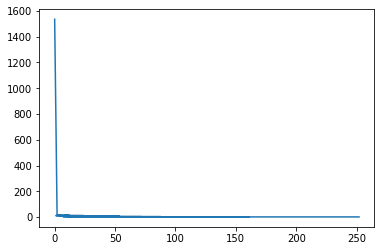

In [ ]:
plt.plot(data['(AC, ALTV)'].value_counts())

Бинаризуем выборку, так как нулей намного больше, чем остальных значений. Пересчитаем таблицу. 

In [ ]:
data.loc[data['(AC, ALTV)'] != 0, '(AC, ALTV)'] = 1

In [ ]:
Single_term = pd.DataFrame(columns=['features', 'p-val'])
for i in range(1,len(cc)):
    model = sm.GLM(data.NSP,  
                pd.concat([data.drop(columns='NSP').iloc[:, :number_all_param],
                           data.iloc[:, number_all_param+i]], 
                           axis=1),
                       family=sm.families.Binomial()).fit()
    lr = lrtest(result_m3.llf, model.llf)
    Single_term = Single_term.append({'features': data.columns[number_all_param+i], 'p-val':  round(chi2.sf(lr, 1), 3)}, ignore_index=True)
Single_term

/usr/local/lib/python3.7/dist-packages/statsmodels/genmod/families/family.py:890: RuntimeWarning: invalid value encountered in true_divide
  n_endog_mu = self._clean((1. - endog) / (1. - mu))
/usr/local/lib/python3.7/dist-packages/statsmodels/genmod/families/family.py:942: RuntimeWarning: divide by zero encountered in true_divide
  special.gammaln(n - y + 1) + y * np.log(mu / (1 - mu)) +
/usr/local/lib/python3.7/dist-packages/statsmodels/genmod/families/family.py:943: RuntimeWarning: divide by zero encountered in log
  n * np.log(1 - mu)) * var_weights
/usr/local/lib/python3.7/dist-packages/statsmodels/genmod/families/family.py:943: RuntimeWarning: invalid value encountered in add
  n * np.log(1 - mu)) * var_weights


,features,p-val
0,"(AC, FM)",0.526
1,"(AC, UC)",0.153
2,"(AC, DP)",0.380
3,"(AC, ASTV)",0.813
4,"(AC, ALTV)",0.073
5,"(AC, Max)",0.281
6,"(AC, Nmax)",0.830
7,"(AC, Mode)",0.268
8,"(AC, Median)",0.145
9,"(FM, UC)",0.931


Попробуем добавить несколько наиболее значимых:

In [ ]:
data.columns

Index(['AC', 'FM', 'UC', 'DP', 'ASTV', 'ALTV', 'Max', 'Nmax', 'Mode', 'Median',
       'NSP', 'const', 'Tendency1', 'Tendency-1', '(AC, FM)', '(AC, UC)',
       '(AC, DP)', '(AC, ASTV)', '(AC, ALTV)', '(AC, Max)', '(AC, Nmax)',
       '(AC, Mode)', '(AC, Median)', '(FM, UC)', '(FM, DP)', '(FM, ASTV)',
       '(FM, ALTV)', '(FM, Max)', '(FM, Nmax)', '(FM, Mode)', '(FM, Median)',
       '(UC, DP)', '(UC, ASTV)', '(UC, ALTV)', '(UC, Max)', '(UC, Nmax)',
       '(UC, Mode)', '(UC, Median)', '(DP, ASTV)', '(DP, ALTV)', '(DP, Max)',
       '(DP, Nmax)', '(DP, Mode)', '(DP, Median)', '(ASTV, ALTV)',
       '(ASTV, Max)', '(ASTV, Nmax)', '(ASTV, Mode)', '(ASTV, Median)',
       '(ALTV, Max)', '(ALTV, Nmax)', '(ALTV, Mode)', '(ALTV, Median)',
       '(Max, Nmax)', '(Max, Mode)', '(Max, Median)', '(Nmax, Mode)',
       '(Nmax, Median)', '(Mode, Median)'],
      dtype='object')

In [ ]:
Single_term = pd.DataFrame(columns=['features', 'p-val'])
for i in range(1,len(cc)):
    model = sm.GLM(data.NSP,  
                pd.concat([data.drop(columns='NSP').iloc[:, :number_all_param],
                           data.iloc[:, number_all_param+i]], 
                           axis=1),
                       family=sm.families.Binomial()).fit()
    lr = lrtest(result_m3.llf, model.llf)
    if round(chi2.sf(lr, 1), 3) < 0.01:
      Single_term = Single_term.append({'features': data.columns[number_all_param+i], 'p-val':  round(chi2.sf(lr, 1), 3)}, ignore_index=True)
Single_term

/usr/local/lib/python3.7/dist-packages/statsmodels/genmod/families/family.py:890: RuntimeWarning: invalid value encountered in true_divide
  n_endog_mu = self._clean((1. - endog) / (1. - mu))
/usr/local/lib/python3.7/dist-packages/statsmodels/genmod/families/family.py:942: RuntimeWarning: divide by zero encountered in true_divide
  special.gammaln(n - y + 1) + y * np.log(mu / (1 - mu)) +
/usr/local/lib/python3.7/dist-packages/statsmodels/genmod/families/family.py:943: RuntimeWarning: divide by zero encountered in log
  n * np.log(1 - mu)) * var_weights
/usr/local/lib/python3.7/dist-packages/statsmodels/genmod/families/family.py:943: RuntimeWarning: invalid value encountered in add
  n * np.log(1 - mu)) * var_weights


,features,p-val
0,"(UC, ASTV)",0.000
1,"(UC, ALTV)",0.003
2,"(ASTV, Mode)",0.003
3,"(ASTV, Median)",0.007
4,"(ALTV, Max)",0.009
5,"(ALTV, Mode)",0.000
6,"(ALTV, Median)",0.000
7,"(Max, Nmax)",0.001
8,"(Nmax, Median)",0.002


In [ ]:
data = data[['AC','UC','DP',
             'ASTV','ALTV',
             'Max','Nmax','Mode',
             'NSP','const',
             'Tendency1','Tendency-1',
             '(UC, ASTV)', '(UC, ALTV)', '(ASTV, Mode)', '(ASTV, Median)', '(ALTV, Max)', '(ALTV, Mode)', '(ASTV, Mode)', '(Max, Nmax)', '(Nmax, Median)']]

In [ ]:
m4 = sm.GLM(data.NSP, data.drop(columns=['NSP']),
                       family=sm.families.Binomial())
result_m4 = m4.fit()
result_m4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    NSP   No. Observations:                 1831
Model:                            GLM   Df Residuals:                     1812
Model Family:                Binomial   Df Model:                           18
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -59.434
Date:                Thu, 01 Apr 2021   Deviance:                       118.87
Time:                        21:49:11   Pearson chi2:                     214.
No. Iterations:                    12                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
AC                -2.1196      0.529     -4.010      0.000      -3.156      -1.083
UC                 1.5264      0.441      3.459      0.001       0.661       2.391
DP                 3.9460      0.673      5.867      0.000       2.628       5.264
ASTV               0.0904      0.150      0.603      0.547      -0.204       0.385
ALTV               0.0886      0.152      0.583      0.560      -0.209       0.387
Max                0.2110      0.048      4.375      0.000       0.117       0.306
Nmax               4.9851      1.554      3.209      0.001       1.940       8.030
Mode              -0.2697      0.071     -3.803      0.000      -0.409      -0.131
const            -15.1442     11.189     -1.353      0.176     -37.075       6.787
Tendency1          2.3602      0.762      3.099      0.002       0.867       3.853
Tendency-1        -1.5827      0.996     -1.589      0.112      -3.535       0.370
(UC, ASTV)        -0.0378      0.008     -4.625      0.000      -0.054      -0.022
(UC, ALTV)        -0.0009      0.005     -0.161      0.872      -0.011       0.010
(ASTV, Mode)       0.0018      0.001      2.775      0.006       0.001       0.003
(ASTV, Median)    -0.0022      0.001     -2.292      0.022      -0.004      -0.000
(ALTV, Max)       -0.0041      0.002     -2.607      0.009      -0.007      -0.001
(ALTV, Mode)       0.0044      0.001      3.162      0.002       0.002       0.007
(ASTV, Mode)       0.0018      0.001      2.775      0.006       0.001       0.003
(Max, Nmax)       -0.0157      0.005     -3.011      0.003      -0.026      -0.005
(Nmax, Median)    -0.0209      0.009     -2.365      0.018      -0.038      -0.004
==================================================================================
"""

In [ ]:
lr = lrtest(result_m3.llf,result_m4.llf)
print('Likelihood Ratio Test Of Nested Models, p: %.03f' % chi2.sf(lr, 1))

Likelihood Ratio Test Of Nested Models, p: 0.000


По критерию отношения правдоподобия получается лучше, однако часть коэффициентов модели незначимы. Проверим, что можно безболезненно удалить:

In [ ]:
Single_term = pd.DataFrame(columns=['features', 'p-val'])
for i in data.drop(columns = ['NSP', 'const']).columns:
    model = sm.GLM(data.NSP, data.drop(columns=['NSP', i]),
                       family=sm.families.Binomial()).fit()
    lr = lrtest(model.llf, result_m4.llf)
    Single_term = Single_term.append({'features': i, 'p-val':  round(chi2.sf(lr, 1), 3)}, ignore_index=True)
Single_term.style.applymap(lambda x: 'background-color : yellow' if x>0.1
                           else '', subset=pd.IndexSlice[:, ['p-val']])

,features,p-val
0,AC,0.000000
1,UC,0.001000
2,DP,0.000000
3,ASTV,0.536000
4,ALTV,0.555000
5,Max,0.000000
6,Nmax,0.000000
7,Mode,0.000000
8,Tendency1,0.001000
9,Tendency-1,0.101000


Удалим DP ASTV, ASTV Mode и ASTV:

In [ ]:
daya_bkp = data.copy()
data = data.drop(columns = ['ASTV' , 'ALTV','Tendency-1', '(UC, ALTV)'])
data = data.astype('float32')

In [ ]:
m5 = sm.GLM(data.NSP, data.drop(columns=['NSP']),
                       family=sm.families.Binomial())
result_m5 = m5.fit()
result_m5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    NSP   No. Observations:                 1831
Model:                            GLM   Df Residuals:                     1821
Model Family:                Binomial   Df Model:                            9
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -61.553
Date:                Thu, 01 Apr 2021   Deviance:                       123.11
Time:                        21:56:14   Pearson chi2:                     218.
No. Iterations:                    46                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
AC                -2.0252      0.526     -3.850      0.000      -3.056      -0.994
UC                 1.3669      0.404      3.383      0.001       0.575       2.159
DP                 3.9863      0.658      6.054      0.000       2.696       5.277
Max                0.1790      0.037      4.832      0.000       0.106       0.252
Nmax               4.9030      1.285      3.815      0.000       2.384       7.422
Mode              -0.2804      0.047     -6.009      0.000      -0.372      -0.189
const             -8.3967      4.887     -1.718      0.086     -17.975       1.182
Tendency1          2.3568      0.673      3.503      0.000       1.038       3.675
(UC, ASTV)        -0.0343      0.007     -4.971      0.000      -0.048      -0.021
(ASTV, Mode)       0.0018      0.000      3.883      0.000       0.001       0.003
(ASTV, Median)    -0.0017      0.001     -2.059      0.040      -0.003   -8.23e-05
(ALTV, Max)       -0.0037      0.001     -3.133      0.002      -0.006      -0.001
(ALTV, Mode)       0.0045      0.001      3.567      0.000       0.002       0.007
(ASTV, Mode)       0.0018      0.000      3.883      0.000       0.001       0.003
(Max, Nmax)       -0.0142      0.004     -3.454      0.001      -0.022      -0.006
(Nmax, Median)    -0.0217      0.008     -2.592      0.010      -0.038      -0.005
==================================================================================
"""

In [ ]:
lr = lrtest(result_m5.llf,result_m4.llf)
print('Likelihood Ratio Test Of Nested Models, p: %.03f' % chi2.sf(lr, 1))

Likelihood Ratio Test Of Nested Models, p: 0.040


In [ ]:
lr = lrtest(result_m3.llf,result_m5.llf)
print('Likelihood Ratio Test Of Nested Models, p: %.03f' % chi2.sf(lr, 1))

Likelihood Ratio Test Of Nested Models, p: 0.000


Получаем, что пятая модель чуть хуже 4 и лучше 3.


## Модель 6

Попробуем удалить влиятельные наблюдения:

In [ ]:
infl = result_m5.get_influence()
sm_fr = infl.summary_frame()


0       3.307337e-17
1       2.099731e-12
2       8.885472e-14
3       3.929435e-17
4       3.042679e-15
            ...     
1826    3.263487e-09
1827    1.575720e-11
1828    3.020519e-08
1829    6.095623e-08
1830    3.313396e-02
Name: cooks_d, Length: 1831, dtype: float64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Cooks distance')

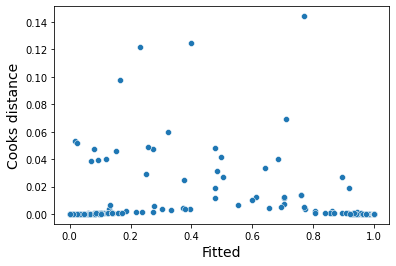

In [ ]:
sns.scatterplot(result_m5.fittedvalues,sm_fr.cooks_d)
plt.xlabel('Fitted', fontsize=14)
plt.ylabel('Cooks distance', fontsize=14)

In [ ]:
data_del = data[sm_fr.cooks_d <= 0.05]

In [ ]:
m6 = sm.GLM(data_del.NSP, data_del.drop(columns=['NSP']),
                       family=sm.families.Binomial())
result_m6 = m6.fit()
[result_m6.params - result_m5.params]
lr = lrtest(result_m5.llf,result_m6.llf)

#плохо
print('Likelihood Ratio Test Of Nested Models, p: %.03f' % chi2.sf(lr, 1))

#лучше
print((result_m6.params - result_m5.params)/result_m5.params)

Likelihood Ratio Test Of Nested Models, p: 0.000
AC                0.521640
UC                0.325642
DP                0.183686
Max               0.300403
Nmax              0.049578
Mode              0.410664
const            -0.390963
Tendency1         0.419114
(UC, ASTV)        0.325148
(ASTV, Mode)      0.505590
(ASTV, Median)    0.771085
(ALTV, Max)       0.371905
(ALTV, Mode)      0.355245
(ASTV, Mode)      0.505590
(Max, Nmax)       0.133277
(Nmax, Median)    0.087610
dtype: float64


Различия небольшие, так что оставим модель, настроенную на полных данных.

## Итог
Посмотрим на качество классификации:

0.9979092282340016

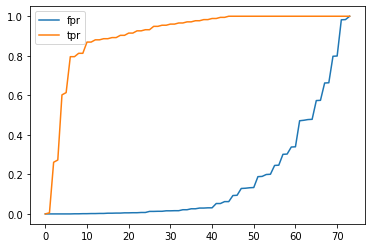

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
pred = np.asarray(m5.predict(result_m5.params))
real = np.asarray(data.NSP)
fpr, tpr, thresholds = roc_curve(real, pred)
plt.plot(fpr, label = 'fpr')
plt.plot(tpr, label = 'tpr')
plt.legend(fontsize=10)
roc_auc_score(real,pred)

0.9973976929414995

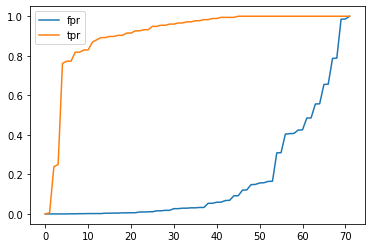

In [ ]:
pred2 = np.matmul(data.drop(columns=['NSP']).to_numpy(), result_m6.params.to_numpy().transpose())
fpr, tpr, thresholds = roc_curve(real, pred2)
plt.plot(fpr, label = 'fpr')
plt.plot(tpr, label = 'tpr')
plt.legend(fontsize=10)
roc_auc_score(real,pred2)

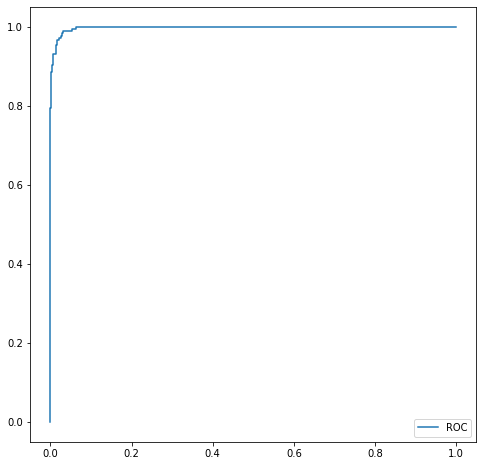

In [ ]:
plt.figure(figsize=(8,8))
plt.plot(fpr, tpr, label = 'ROC')
plt.legend(fontsize=10)

In [ ]:
roc_auc_score(real,pred)

0.9979092282340016

In [ ]:
lr = lrtest(result_m0.llf,result_m5.llf)
print('Likelihood Ratio Test Of Nested Models, p: %f' % chi2.sf(lr, 1))

Likelihood Ratio Test Of Nested Models, p: 0.000000


Площадь под ROC-кривой составляет 0.997. 

In [ ]:
type(1/np.exp(result_m5.params)*np.sign(result_m5.params))

pandas.core.series.Series

In [ ]:
df = (1/np.exp(result_m5.conf_int()))
df = pd.concat([df,1/np.exp(result_m5.params)*np.sign(result_m5.params)], axis = 1)
df.columns = ['low_conf', 'up_conf', 'params']
df

,low_conf,up_conf,params
AC,2.124599e+01,2.702677,-7.577667
UC,5.627064e-01,0.115465,0.254898
DP,6.749485e-02,0.005108,0.018568
Max,8.990842e-01,0.777592,0.836134
Nmax,9.215479e-02,0.000598,0.007424
Mode,1.450444e+00,1.207989,-1.323677
const,6.405668e+07,0.306705,-4432.439267
Tendency1,3.541428e-01,0.025337,0.094725
"(UC, ASTV)",1.048996e+00,1.020998,-1.034902
"(ASTV, Mode)",9.991054e-01,0.997285,0.998195


Расшифровки обозначений для признаков в финальной модели:

- AC - число ускорений в секунду;
- UC - число сокращений матки;
- DP - число длительных замедлений в секунду;
- ALTV - процент абнормальных долгосрочных изменений;
- ASTV - процент абнормальных краткосрочных изменений;
- Max - максимум гистограммы FHR;
- Nmax - число раз, которое достигается максимум в гистограмме FHR;
- Mode - мода гистограммы FHR
- Tendency - тенденция гистограммы FHR: -1 = левая асимметричный; 0 = симметричная; 1 = правая асимметричная.

Выводы:

* С ростом числа ускорений в секунду на единицу риск патологии уменьшается в 4.780 раз [9.275, 2.463].

* С увеличением на единицу числа длительных замедлений в секунду риск патологии увеличивается в 5.049 раз [0.019,0.002].

* Увеличение на процент доли абнормальных долгосрочных изменений связано с ростом риска патологии в 0.925 раз [0.94, 0.91].

* С увеличением на единицу максимума гистограммы FHR риск патологии увеличивается в 0.91 раз [1.937, 1.269].

* C каждым дополнительным максимумом гистограммы FHR риск патологии уменьшается в  1.568 раз [1.937, 1.269].

* Увеличение на единицу моды гистограммы FHR связано с уменьшением риска патологии в 1.135 раз [1.170, 1.102].

* При наличии левой ассиметрии гистограммы FHR риск патологии уменьшается в 3.069 раз [9.258, 1.017]

* При наличии правой ассиметрии гистограммы FHR риск патологии увеличивается в 0.251 раз [0.57, 0.109]

* Увеличение на процент доли абнормальных краткосрочных изменений при минимальном значении числа сокращений матки 0 связано с
увеличением риска патологии в 0.985 раз [0.993, 0.977].


Все приведённые доверительные интервалы построены на уровне доверия 95%.